# Описание проекта

Отделом маркетинга крупного интернет-магазина подготовлен список гипотез (файл hypothesi) для увелчения выручки. Был проведен А/Б тест, результаты содержатся в файлах orders (заказы) и visitors (клиенты). 

**Цель исследования:** приоритизировать гипотезы, проанализировать результаты А/Б теста и принять решение по результатам теста.

Содержание:
1. [Загрузка данных и подготовка к анализу](#1);
2. [Приоритизация гипотез](#2);
3. [Анализ A/B-теста](#3);
4. [Итоговый вывод](#4)

## Загрузка данных и подготовка к анализу
<a id='1'></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
# проверка на наличие дубликатов
for i in [hypothesis, orders, visitors]:
    print(i.duplicated().sum())

0
0
0


In [4]:
# проверка на наличие пропусков
for i in [hypothesis, orders, visitors]:
    display(pd.DataFrame(round((i.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
Hypothesis,0.00
Reach,0.00
Impact,0.00
Confidence,0.00
Efforts,0.00


,"NaNs, %"
transactionId,0.00
visitorId,0.00
date,0.00
revenue,0.00
group,0.00


,"NaNs, %"
date,0.00
group,0.00
visitors,0.00


In [5]:
display(hypothesis.head())
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={
    'transactionId': 'transaction_id', 
    'visitorId': 'visitor_id', 
    'session end': 'session_end'})
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [7]:
# сохраняем id пользователей, которые попали в обе группы
cross_users = (
    orders[orders['group'] == "A"]
    .merge(orders[orders['group'] == "B"], on='visitor_id', how='inner')['visitor_id']
    .unique()
)
len(cross_users)

58

In [8]:
# доля пересекающихся пользователей
len(cross_users) / len(orders['visitor_id'].unique())

0.05625606207565471

In [9]:
# удаляем пересекающихся пользователей
orders_filtered = orders[~orders['visitor_id'].isin(cross_users)]

In [10]:
len(orders_filtered['visitor_id'].unique())

973

**Вывод**: данные подготовлены для дальнейшего анализа, пропуски и дубликаты отсутствуют. Удалены пересекающиеся пользователи.

## Приоритизация гипотез
<a id='2'></a>

In [11]:
# применяем фреймворк ICE = Impact * Confidence / Efforts
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='ice', ascending=False)[['hypothesis', 'ice']]

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Наиболее перспективные гипотезы: 8,0,7,6.

In [12]:
# применяем фреймворк RICE = Reach * Impact * Confidence / Efforts
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='rice', ascending=False)[['hypothesis', 'rice']]

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


In [13]:
pd.set_option('display.max_colwidth', 0)
display(hypothesis.sort_values((['ice', 'rice']), ascending=[False,False]))

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Наиболее перспективные гипотезы: 7,2,0,6. В отличие от ICE, по фреймворку RICE наиболее перспективная гипотеза под номером 7, т.к. в формуле учитывается значение по охвату пользователей (у гипотезы 7 максимальное значение reach). Наоборот, гипотеза 8 в RICE лишь на пятом месте, т.к. она затрагивает наименьшее количество пользователей.

## Анализ A/B-теста
<a id='3'></a>

### Расчет кумулятивных метрик

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders_filtered[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups.apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'], orders_filtered['group'] == x['group'])]
                      .agg(
                          {'date' : 'max', 
                           'group' : 'max', 
                           'transaction_id' : 'nunique', 
                           'visitor_id' : 'nunique', 
                           'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                      .agg(
                          {'date' : 'max', 
                           'group' : 'max', 
                           'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group']))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


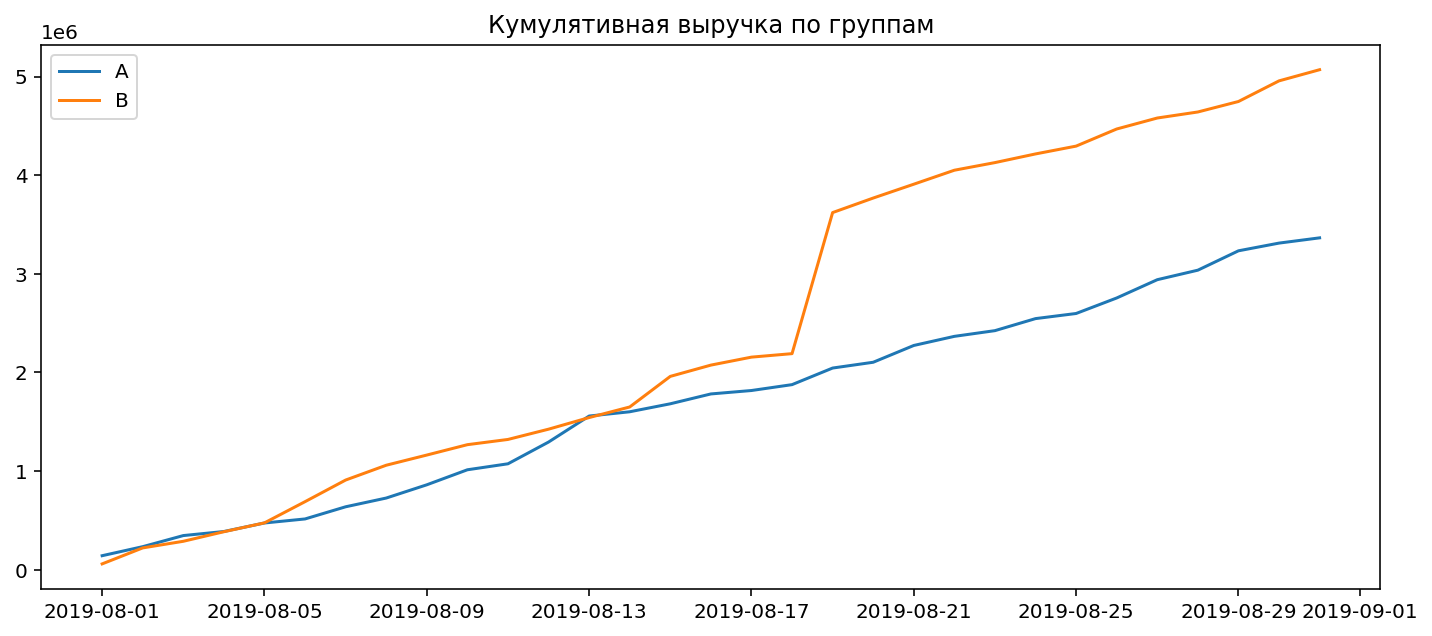

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
fig = plt.figure(figsize=(12,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.show()

Выручки по обоим группам стабильно растут, группа В показывает более высокий результат. 19 августа наблюдается резкий рост выручки, что может быть обусловлено всплеском заказов либо наличием аномально дорогих заказов.

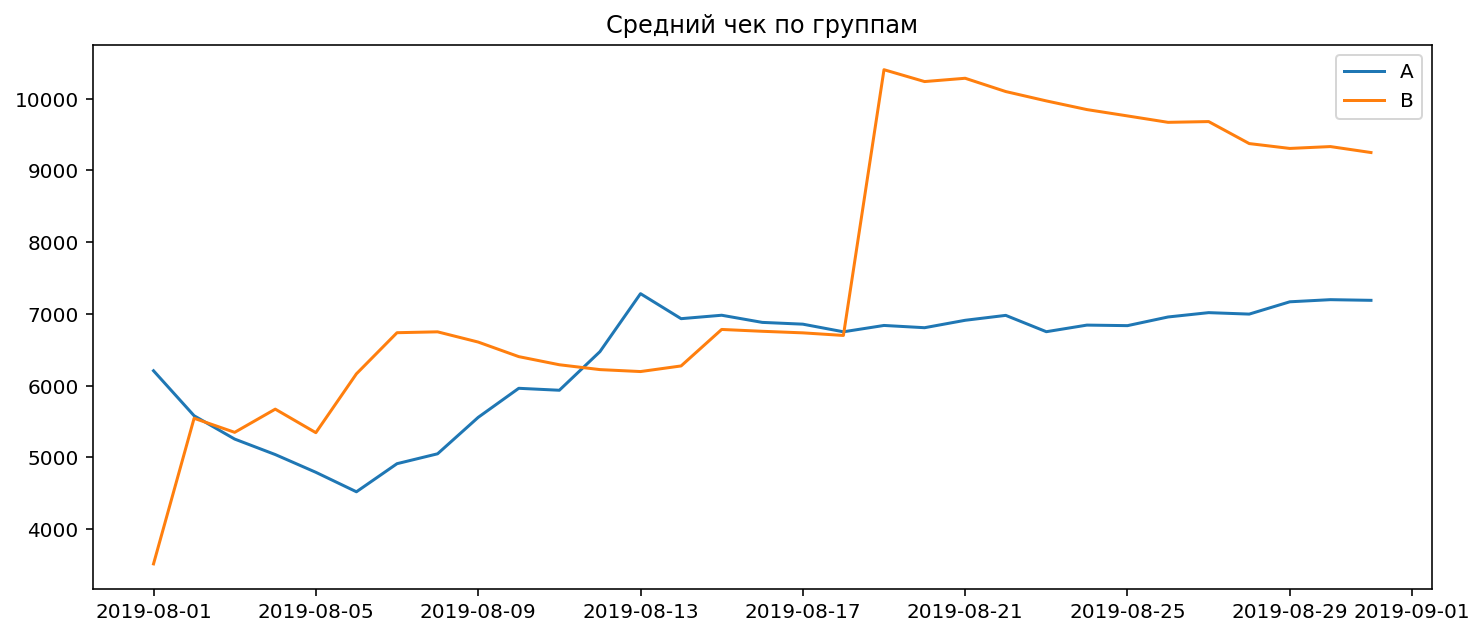

In [16]:
# строим график среднего чека
fig = plt.figure(figsize=(12,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('Средний чек по группам')
plt.show()

19 августа средний чек по группе В резко вырос, вероятно наличие очень дорогих заказов. В дальнейшем средний чек по группе В плавно снижался, по группе А стабилизировался на отметке около 7000.

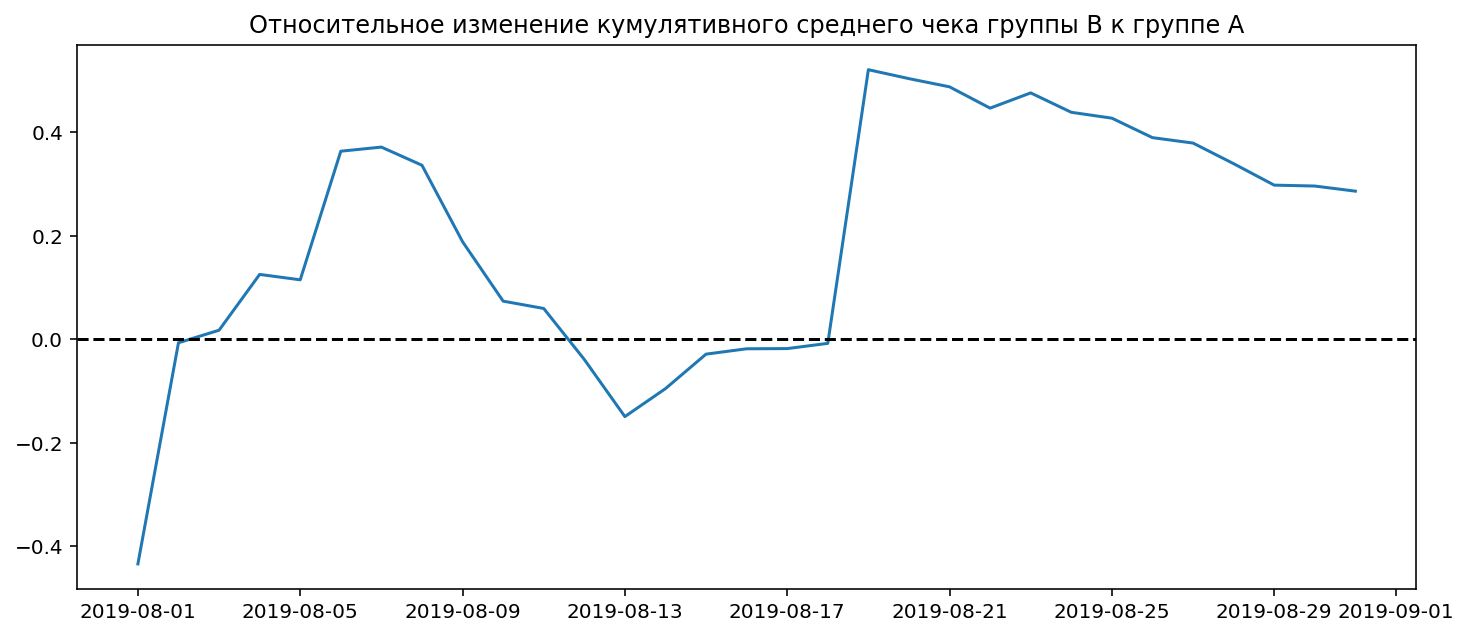

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig = plt.figure(figsize=(12,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

График резко меняется в нескольких точках, что говорит о возможных выбросах в количестве покупателей или среднем чеке.

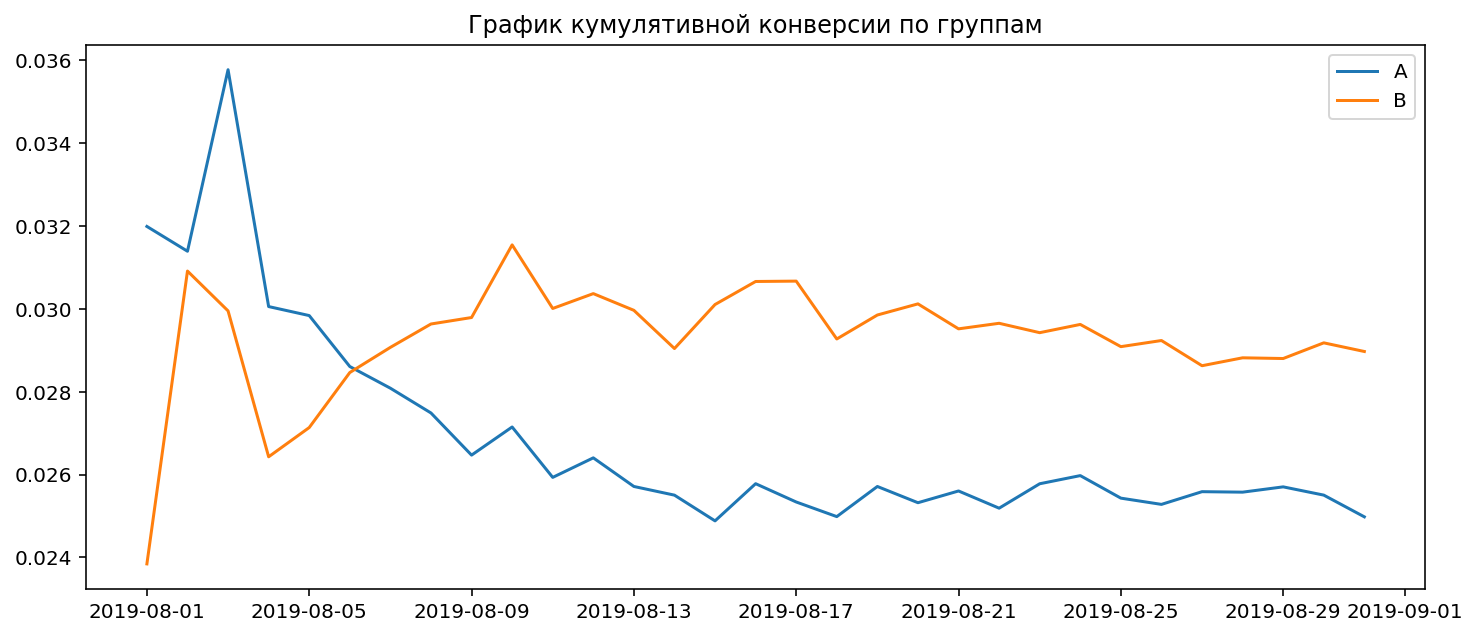

In [18]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig = plt.figure(figsize=(12,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.show()

Конверсии обеих групп начинают стабилизироваться: 0.029 у группы В и 0.025 у А.

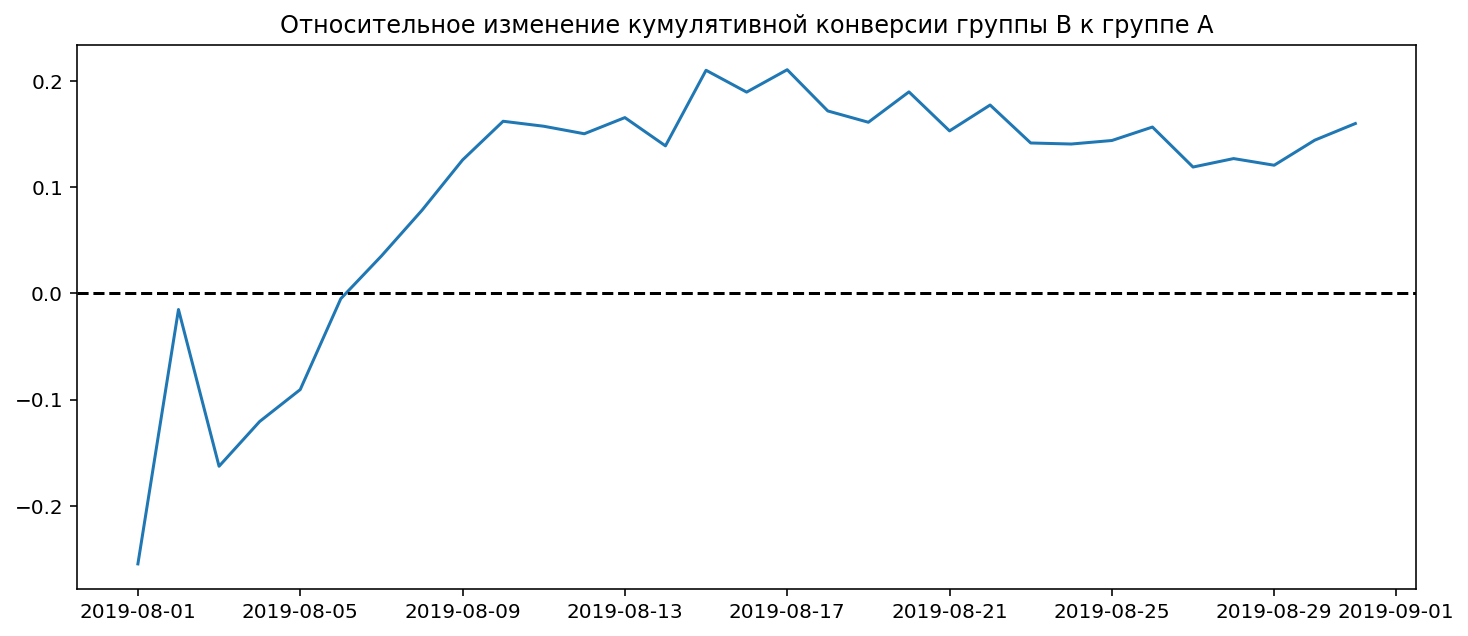

In [19]:
# строим график относительного различия кумулятивных конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize=(12,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.show()

В начале периода у группы А конверсия была выше, однако после 6 августа конверсия группы В стабильно выше.

### Поиск выбросов

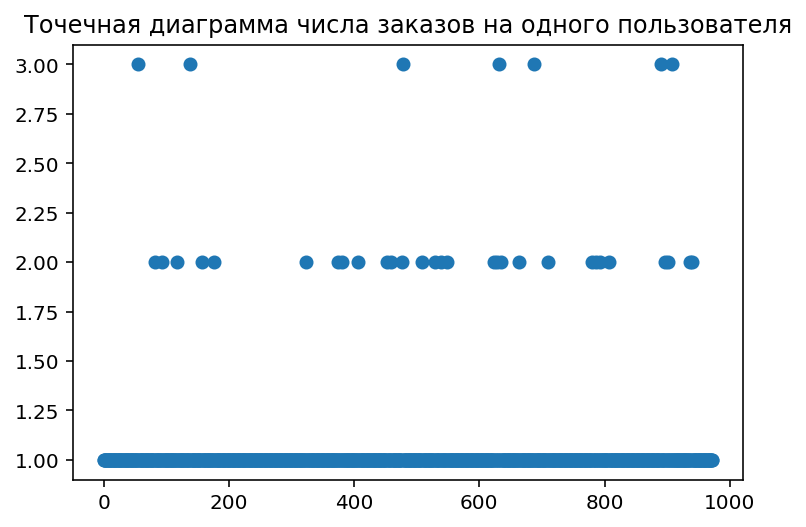

In [20]:
# группируем пользователей по количеству заказов
ordersByUsers = (
    orders_filtered.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['user_id', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False)

# строим точечный график количества заказов по пользователям
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()

Большинство пользователей совершали не более одного заказа.

In [21]:
# считаем 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформили больше одного заказа, более 2-х заказов лишь у 1%. Выберем верхнюю границу для определения аномальных пользователей - не более 1 заказа.

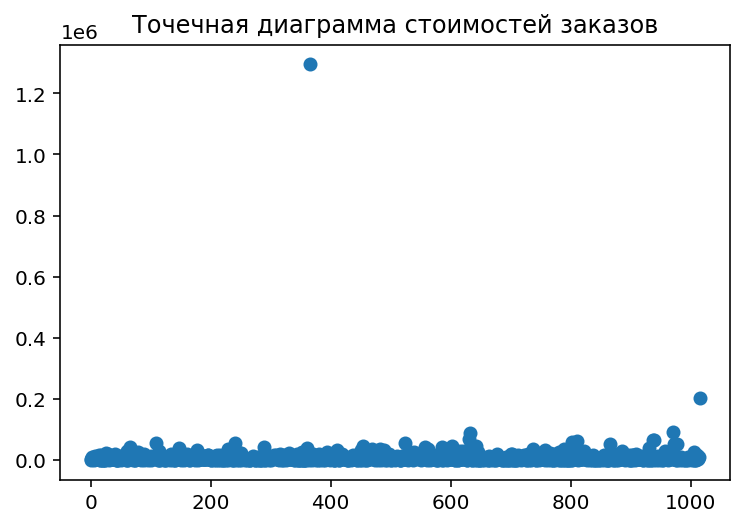

In [22]:
# строим точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders_filtered)))
plt.scatter(x_values, orders_filtered['revenue'])
plt.title('Точечная диаграмма стоимостей заказов')
plt.show()

Есть заказы с аномально высокой стоимостью - более 1.2 и 0.2. Выбросы могут повлиять на результаты анализа.

In [23]:
# считаем 95-й и 99-й перцентили стоимости заказов
print(np.percentile(orders_filtered['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% пользователей оформили заказы стоимостью выше 26785, стоимость заказов выше 53904 лишь у 1%. Выберем верхнюю границу для определения аномальных заказов - стоимость не более 26785.

### Расчет статистической значимости

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders_filtered[orders_filtered['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders_filtered[orders_filtered['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами по "сырым" данным. **Сформулируем гипотезы.** Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

In [25]:
ordersByUsersA = (
    orders_filtered[orders_filtered['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders_filtered[orders_filtered['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


**Вывод**: p-value=0.011 меньше уровня значимости 0.05, значит нулевая гипотеза отвергается - по "сырым" данным между группами есть статистическая разница в конверсии. В относительном выражении конверсия группы В больше на 16%.

Посчитаем статистическую значимость различий в среднем чеке между группами по "сырым" данным. **Сформулируем гипотезы.** Нулевая: различий в среднем чеке между группами нет. Альтернативная: различия в среднем чеке между группами есть.

In [26]:
(
    print('{0:.3f}'.format(stats.mannwhitneyu(orders_filtered[orders_filtered['group']=='A']['revenue'], 
                                          orders_filtered[orders_filtered['group']=='B']['revenue'])[1]))
)
(
    print('{0:.3f}'.format(orders_filtered[orders_filtered['group']=='B']['revenue'].mean()/
                           orders_filtered[orders_filtered['group']=='A']['revenue'].mean()-1))
)

0.829
0.287


**Вывод:** p-value=0.829 больше уровня значимости 0.05, значит нет оснований отвергать нулевую гипотезу - по "сырым" данным нет статистически значимых различий в среднем чеке. При этом в относительном выражении средний чек группы В больше на 28.7%.

Повторим расчеты по очищенным от выбросов данным. Ранее были определены критерии аномальных заказов: не более 1 заказа, стоимость не более 26785.

In [27]:
# посчитаем количество аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders_filtered[orders_filtered['revenue'] > 26785]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
86


Всего 86 аномальных пользователей, исключим их из выборки.

Посчитаем статистическую значимость различия в конверсии между группами по очищенным данным. **Сформулируем гипотезы.** Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

In [28]:
# считаем статистическую значимость различия в конверсии между группами по очищенным данным
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.016
0.174


**Вывод:** результат практически не изменился - без учета аномальных пользователей между группами по-прежнему есть статистически значимая разница в конверсии.

Посчитаем статистическую значимость различий в среднем чеке между группами по очищенным данным. **Сформулируем гипотезы.** Нулевая: различий в среднем чеке между группами нет. Альтернативная: различия в среднем чеке между группами есть.

In [29]:
# считаем статистическую значимость различий в среднем чеке между группами по очищенными данным
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders_filtered[
                np.logical_and(
                    orders_filtered['group'] == 'A',
                    np.logical_not(orders_filtered['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders_filtered[
                np.logical_and(
                    orders_filtered['group'] == 'B',
                    np.logical_not(orders_filtered['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders_filtered[
            np.logical_and(
                orders_filtered['group'] == 'B',
                np.logical_not(orders_filtered['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders_filtered[
            np.logical_and(
                orders_filtered['group'] == 'A',
                np.logical_not(orders_filtered['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.727
-0.034


**Вывод:** результат также почти не изменился - статистически значимых различий в среднем чеке по очищенным данным нет. Однако в относительном выражении без учета выбросов средний чек группы А больше на 3.4% - разница между сегментами значительно сократилась.

## Итоговый вывод
<a id='4'></a>

По результатам анализа А/В теста получены следующие результаты:
- кумулятивные метрики по выручке, среднему чеку и конверсии в основном лидируют у группы В;
- конверсия по группе В выше конверсии по группе А на 17% (по очищенным данным) и 16% (по "сырым" данным), разница является статистически значимой;
- статистически значимых различий в среднем чеке нет как по очищенным данным, так и по "сырым".

Учитывая, что получена статистически значимая разница в конверсии, целесообразно остановить тест и зафикисровать победу группы В.